In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

ModuleNotFoundError: No module named 'pingouin'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/sample_data/assessment_da25.csv')

Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assessment_da25.csv')

Mounted at /content/drive


In [3]:
data

,Variant,Number of page views,GMV (in $),Number of add to cart,Clicks on media,Time on Page (sec),user_id
0,A,5,0.00,0,2,74,0
1,A,4,0.00,4,1,21,1
2,A,4,0.00,2,0,1,2
3,A,5,0.00,0,1,26,3
4,A,5,0.00,3,3,46,4
...,...,...,...,...,...,...,...
1995,B,3,0.00,1,0,1,1995
1996,B,3,0.00,1,2,31,1996
1997,B,3,0.00,2,0,3,1997
1998,B,4,87.08,2,1,11,1998


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Variant                2000 non-null   object 
 1   Number of page views   2000 non-null   int64  
 2   GMV (in $)             2000 non-null   float64
 3   Number of add to cart  2000 non-null   int64  
 4   Clicks on media        2000 non-null   int64  
 5   Time on Page (sec)     2000 non-null   int64  
 6   user_id                2000 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 109.5+ KB


# **Internal validity check: Sample Ratio Mismatch (SRM)**

Checking whether the number of users is not skewed on a specific condition

In [5]:
# Calculate the unique IDs per variant
data.groupby('Variant')['user_id'].nunique()

# Assign the unique counts to each variant
control_users = data[data['Variant']=='A']['user_id'].nunique()
exposed_users = data[data['Variant']=='B']['user_id'].nunique()
total_users = control_users + exposed_users

# Calculate allocation ratios per variant
control_perc = control_users / total_users
exposed_perc = exposed_users / total_users
print("Percentage of users in the control group: ", 100*round(control_perc,5), "%")
print("Percentage of users in the exposed group: ", 100*round(exposed_perc,5), "%")

Percentage of users in the control group:  50.0 %
Percentage of users in the exposed group:  50.0 %


In [6]:
# Create lists of observed and expected counts per variant
observed = [control_users, exposed_users]
expected = [total_users/2, total_users/2]

# Import chisquare from scipy library
from scipy.stats import chisquare

# Run chisquare test on observed and expected lists
chi = chisquare(observed, f_exp=expected)

# Print test results and interpretation
print(chi)
if chi[1] > 0.01 :
	print("SRM may be present")
else:
	print("SRM likely not present")

Power_divergenceResult(statistic=0.0, pvalue=1.0)
SRM may be present


# **Analyzing difference**

1. Number of pages view

In [7]:
# Getting insights of the data. Which variable had a different result depending on the condition?

# Calculate the number of users in groups A and B
n_np_A = data[data['Variant'] == 'A']['Number of page views'].count()
n_np_B = data[data['Variant'] == 'B']['Number of page views'].count()
print('Group A users:', n_np_A)
print('Group B users:', n_np_B)

# Calculate the mean Number of page views rates of group A and B
p_np_A = data[data['Variant'] == 'A']['Number of page views'].mean()
p_np_B = data[data['Variant'] == 'B']['Number of page views'].mean()
print('Group A mean purchase rate:', p_np_A)
print('Group B mean purchase rate:', p_np_B)

Group A users: 1000
Group B users: 1000
Group A mean purchase rate: 4.985
Group B mean purchase rate: 5.317


<ipython-input-8-50d332ae4189>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='Number of page views', y='Variant', inner='box', palette='Set2')


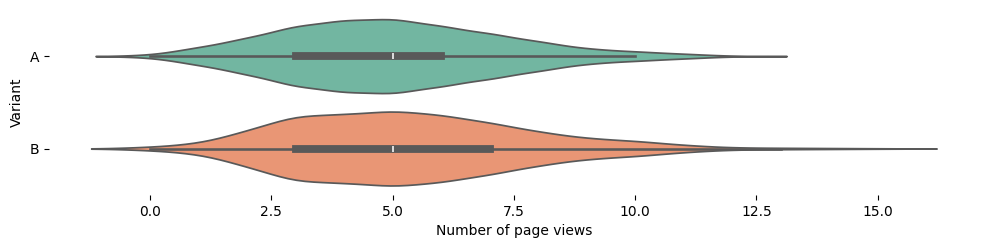

In [8]:
figsize = (12, 1.2 * len(data['Variant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='Number of page views', y='Variant', inner='box', palette='Set2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [19]:
# Calculate the number of users in group A and B
n_np_A = data[data['Variant'] == 'A']['Number of page views'].nunique()
n_np_B = data[data['Variant'] == 'B']['Number of page views'].nunique()

print('Group A users:', n_np_A)
print('Group B users:', n_np_B)

Group A users: 13
Group B users: 16


In [20]:
# Compute unique purchasers in each group
pageviews_A = data[data['Variant'] == 'A'].groupby('user_id')['Number of page views'].max().sum()
pageviews_B = data[data['Variant'] == 'B'].groupby('user_id')['Number of page views'].max().sum()

# Assign groups lists
pageviews_abtest = [pageviews_A, pageviews_B]
n_abtest = [n_np_A, n_np_B]

In [24]:
# Calculate p-value and confidence intervals
z_stat, pvalue = proportions_ztest(pageviews_abtest, n_abtest)

# Calculate confidence intervals
(A_lo95, B_lo95), (A_up95, B_up95) = proportion_confint(pageviews_abtest, nobs=n_abtest, alpha=0.05)

# Print the p-value and confidence intervals
print(f'p-value: {pvalue:.4f}')
print(f'Group A 95% CI : [{A_lo95:.4f}, {A_up95:.4f}]')
print(f'Group B 95% CI : [{B_lo95:.4f}, {B_up95:.4f}]')

p-value: nan
Group A 95% CI : [nan, nan]
Group B 95% CI : [nan, nan]


In [27]:
# Calculate the mean and count of time on page by variant
print(data.groupby('Variant')['Number of page views'].agg({'mean', 'count'}))

# Set random seed for repeatability
np.random.seed(40)

# Take a random sample of size 25 from each variant
ToP_samp_A = data[data['Variant'] == 'A'].sample(25)['Number of page views']
ToP_samp_B = data[data['Variant'] == 'B'].sample(25)['Number of page views']

          mean  count
Variant              
A        4.985   1000
B        5.317   1000


In [28]:
# Run a Mann-Whitney U test
mwu_test = pingouin.mwu(x=ToP_samp_A,
												y=ToP_samp_B,
												alternative='two-sided')

# Print the test results
print(mwu_test)

NameError: name 'pingouin' is not defined

2. Number of add to cart

In [11]:
# Getting insights of the data. Which variable had a different result depending on the condition?

# Calculate the number of users in groups A and B
n_nac_A = data[data['Variant'] == 'A']['Number of add to cart'].count()
n_nac_B = data[data['Variant'] == 'B']['Number of add to cart'].count()
print('Group A users:', n_nac_A)
print('Group B users:', n_nac_B)

# Calculate the mean Number of page views rates of group A and B
p_nac_A = data[data['Variant'] == 'A']['Number of add to cart'].mean()
p_nac_B = data[data['Variant'] == 'B']['Number of add to cart'].mean()
print('Group A mean purchase rate:', p_nac_A)
print('Group B mean purchase rate:', p_nac_B)

Group A users: 1000
Group B users: 1000
Group A mean purchase rate: 1.884
Group B mean purchase rate: 2.469


<ipython-input-6-c7b77773dcbf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='Number of add to cart', y='Variant', inner='box', palette='Set2')


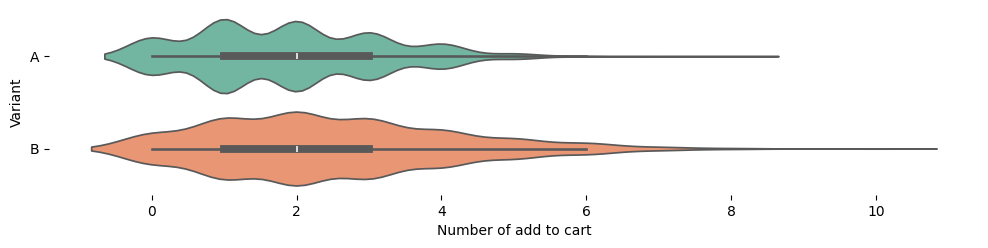

In [ ]:
figsize = (12, 1.2 * len(data['Variant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='Number of add to cart', y='Variant', inner='box', palette='Set2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [13]:
# Calculate the number of users in group A and B
n_nac_A = data[data['Variant'] == 'A']['Number of add to cart'].nunique()
n_nac_B = data[data['Variant'] == 'B']['Number of add to cart'].nunique()

print('Group A users:', n_nac_A)
print('Group B users:', n_nac_B)

Group A users: 8
Group B users: 10


In [ ]:
# Compute unique purchasers in each group
addtocart_A = data[data['Variant'] == 'A'].groupby('user_id')['Number of add to cart'].max().sum()
addtocart_B = data[data['Variant'] == 'B'].groupby('user_id')['Number of add to cart'].max().sum()

# Assign groups lists
addtocart_abtest = [addtocart_A, adtocart_B]
n_abtest = [n_nac_A, n_nac_B]

In [ ]:
# Calculate p-value and confidence intervals
z_stat, pvalue = proportions_ztest(addtocart_abtest, nobs=n_abtest)
(A_lo95, B_lo95), (A_up95, B_up95) = proportion_confint(addtocart_abtest, nobs=n_abtest, alpha=0.05)

# Print the p-value and confidence intervals
pprint(f'p-value: {pvalue:.4f}')
print(f'Group A 95% CI : [{A_lo95:.4f}, {A_up95:.4f}]')
print(f'Group B 95% CI : [{B_lo95:.4f}, {B_up95:.4f}]')

In [ ]:
# 3. Clicks on media
data.groupby('Variant')['Clicks on media'].mean()

Variant
A    1.495
B    1.324
Name: Clicks on media, dtype: float64

<ipython-input-7-d436faf048cf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='Clicks on media', y='Variant', inner='box', palette='Set2')


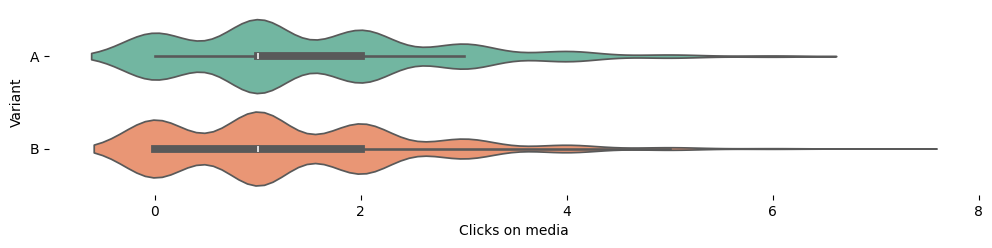

In [ ]:
figsize = (12, 1.2 * len(data['Variant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='Clicks on media', y='Variant', inner='box', palette='Set2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# 4. Time on Page (sec)
data.groupby('Variant')['Time on Page (sec)'].mean()

Variant
A    20.543
B    20.047
Name: Time on Page (sec), dtype: float64

<ipython-input-8-f80713eaf9fa>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='Time on Page (sec)', y='Variant', inner='box', palette='Set2')


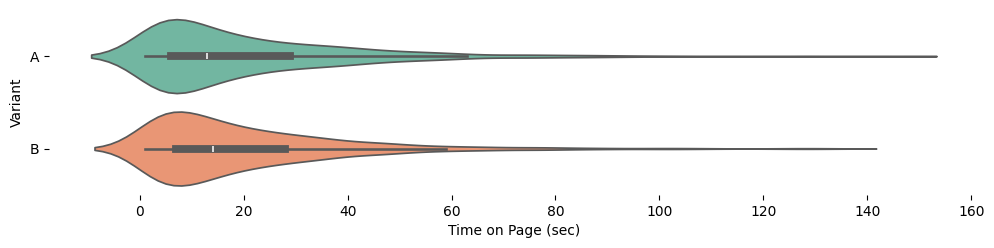

In [ ]:
figsize = (12, 1.2 * len(data['Variant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='Time on Page (sec)', y='Variant', inner='box', palette='Set2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# 5. GMV (in $)
data.groupby('Variant')['GMV (in $)'].mean()

Variant
A    7.68999
B    9.28953
Name: GMV (in $), dtype: float64

<ipython-input-21-5a5a9903ec24>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data, x='GMV (in $)', y='Variant', inner='box', palette='Set2')


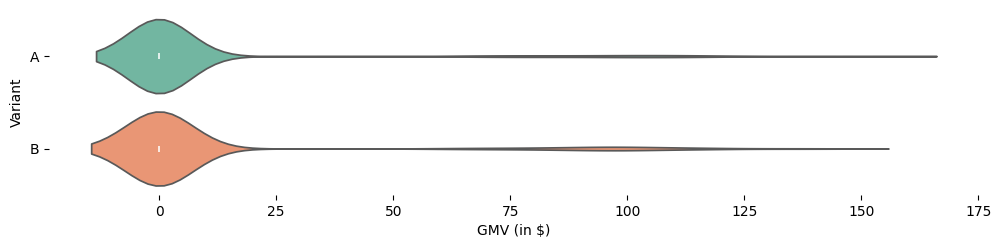

In [ ]:
figsize = (12, 1.2 * len(data['Variant'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(data, x='GMV (in $)', y='Variant', inner='box', palette='Set2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Finding useful metrics - 1. Number of page views
